# **0. 준비**

### **- 모듈/ 라이브러리 import**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from scipy.stats import skew

from pycaret.regression import *

# **1. 데이터 불러오기 & EDA**

### **1-1. 학습 데이터(train data)**

In [2]:
train = pd.read_csv('./datasets/train.csv')
train.head()

,id,temperature,pressure,humidity,wind_speed,wind_direction,precipitation,snowing,cloudiness,target
0,TRAIN_00000,27.8816,1013.6,46.8,2.4,232.4,0.00,False,0.0,1.180
1,TRAIN_00001,5.7540,1026.6,76.6,3.6,172.0,0.00,False,8.8,8.581
2,TRAIN_00002,20.8220,1016.2,64.8,2.2,206.0,0.06,False,23.0,3.978
3,TRAIN_00003,20.0758,1017.4,72.6,0.8,215.4,0.00,False,0.0,8.301
4,TRAIN_00004,7.5260,1023.2,82.8,1.2,158.0,0.00,False,15.0,1.692


- test 데이터를 분석하여 그 정보를 활용하는 것은 **Data Leakage**에 해당하기에 train 데이터만 사용

#### **📌 데이터 정보**  
- id: 샘플 별 고유 id
- temperature: 기온 (°C)
- pressure: 기압 (hPa)
- humidity: 습도 (%)
- wind_speed: 풍속 (m/s)
- wind_direction: 풍향 (degree)
- precipitation: 1시간 강수량 (mm)
- snowing: 눈 오는 상태 여부 (False, True)
- cloudiness: 흐림 정도 (%)
- target(목표 예측값): 풍력 발전량 (GW) 

In [3]:
### 양적 변수 vs 질적 변수
# qualitative: 질적 변수
# quantitative: 양적 변수

qual_df = train[['snowing']] # 유일한 질적 변수
quan_df = train.drop(columns = ['id','snowing'])

 - id 컬럼은 불필요하므로 삭제
 - snowing을 제외한 나머지 컬럼은 질적 변수

In [4]:
### 데이터 정보 확인

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19275 entries, 0 to 19274
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              19275 non-null  object 
 1   temperature     19275 non-null  float64
 2   pressure        19275 non-null  float64
 3   humidity        19275 non-null  float64
 4   wind_speed      19275 non-null  float64
 5   wind_direction  19275 non-null  float64
 6   precipitation   19275 non-null  float64
 7   snowing         19275 non-null  bool   
 8   cloudiness      19275 non-null  float64
 9   target          19275 non-null  float64
dtypes: bool(1), float64(8), object(1)
memory usage: 1.3+ MB


- 결측치는 존재하지 않는다.
- snowing을 제외한 모든 변수들(양적 변수)의 데이터형은 **실수형**이다.

In [5]:
### 기술통계량 확인

train.describe()

,temperature,pressure,humidity,wind_speed,wind_direction,precipitation,cloudiness,target
count,19275.000000,19275.000000,19275.000000,19275.000000,19275.000000,19275.000000,19275.000000,19275.000000
mean,17.288476,1059.825712,68.948763,2.476970,166.578179,0.076572,25.749748,5.477028
std,7.192604,2544.132430,14.856929,1.359942,57.313099,0.193110,17.628612,3.217581
min,-0.208137,812.600000,22.600000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.712000,1012.600000,57.800000,1.400000,127.000000,0.000000,12.000000,2.956000
50%,16.530000,1016.800000,70.800000,2.200000,166.600000,0.000000,23.000000,4.837000
75%,22.559000,1021.000000,80.800000,3.200000,208.000000,0.060000,37.000000,7.436500
max,37.058000,201373.000000,100.000000,29.800000,338.000000,3.180000,93.600000,17.344000


- 데이터 컬럼들의 스케일 차이가 존재함을 확인할 수 있다.

#### **📌 데이터 분포 확인**

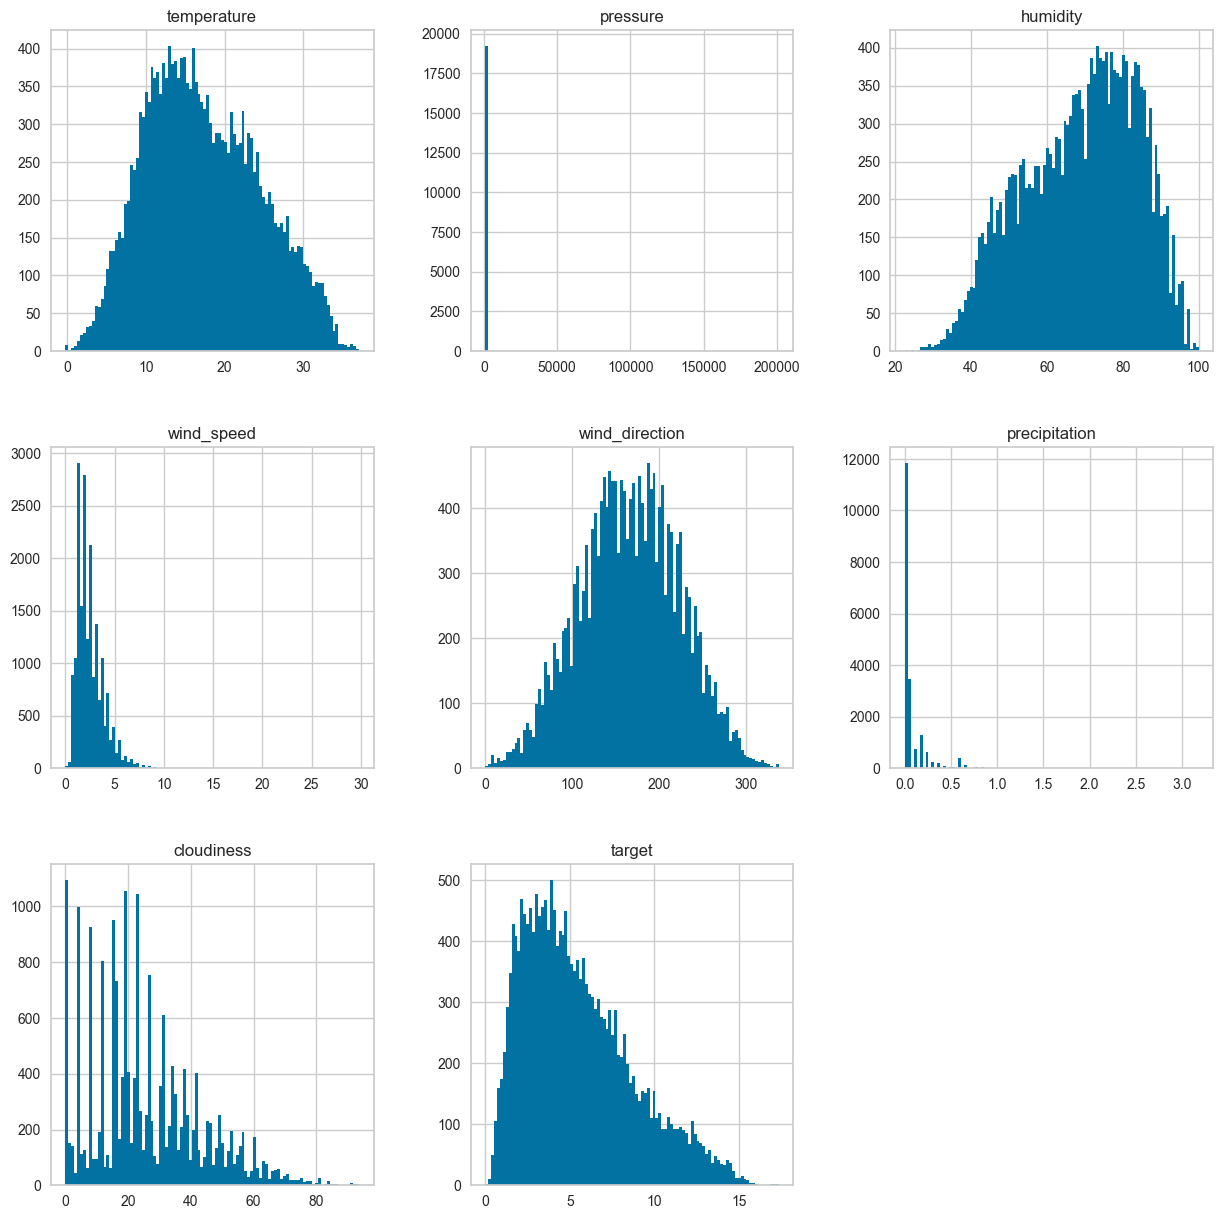

In [6]:
# 양적 변수 -> 히스토그램을 통해 시각화

quan_df.hist(bins = 100, figsize = (15,15))
plt.show()

In [7]:
### 왜도(skewness) 확인

from scipy.stats import skew

# 숫자형 feature의 칼럼 index 추출
features_idx = quan_df.dtypes[quan_df.dtypes != 'object'].index
skew_features = quan_df[features_idx].apply(lambda x:skew(x))
print('전체 왜곡 정도: %f' %skew_features.mean())
print()

### Positive Skew
skew_features_pos = skew_features[skew_features > 0]
print(skew_features_pos.sort_values(ascending = False))

### Negative Skew
print()
skew_features_neg = skew_features[skew_features < 0]
print(skew_features_neg.sort_values(ascending = True))

전체 왜곡 정도: 10.729105

pressure         76.063931
precipitation     6.724946
wind_speed        1.674976
target            0.770833
cloudiness        0.701589
temperature       0.263801
dtype: float64

humidity         -0.327618
wind_direction   -0.039618
dtype: float64


- 데이터가 왜곡된 분포를 가지고 있음을 확인할 수 있다.

<AxesSubplot:xlabel='snowing', ylabel='count'>

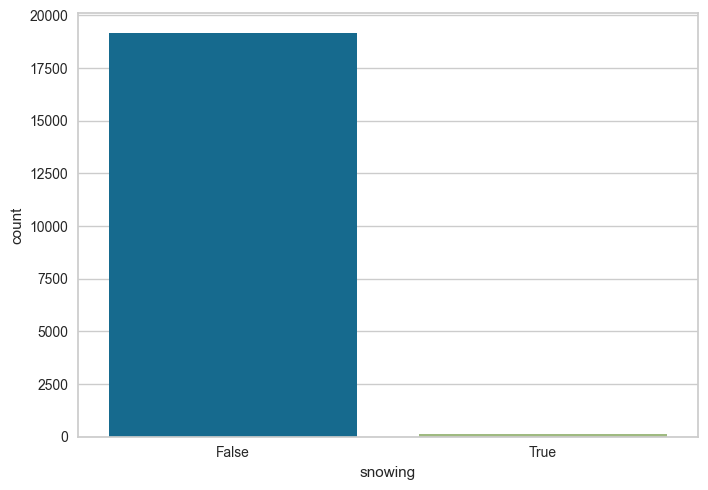

In [8]:
# 질적 변수 -> countplot(빈도) 시각화

sns.countplot(x = qual_df['snowing'])

In [9]:
### 왜도(skewness) 확인

print('왜곡 정도: %f' %skew(qual_df['snowing']))

왜곡 정도: 12.296606


- snowing 컬럼의 경우 굉장히 왜곡된 분포를 가짐을 확인할 수 있다.

#### **📌 상관관계(Correlation)**

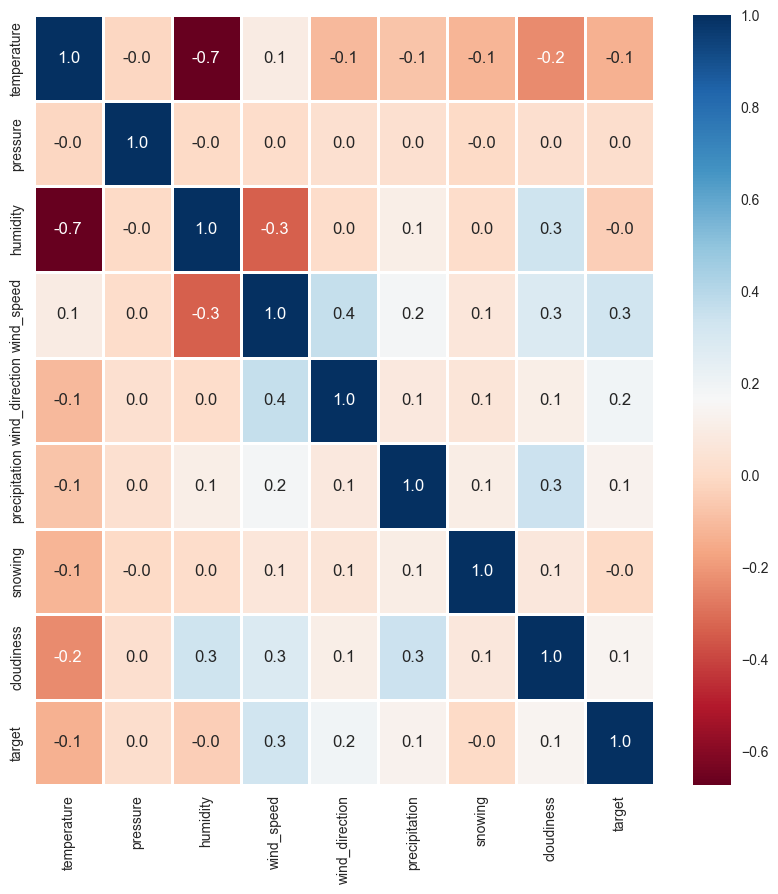

In [10]:
# 상관계수 heatmap 시각화

plt.figure(figsize = (10,10))
sns.heatmap(train.drop(columns = ['id'], axis = 1).corr(), annot = True, fmt = '.1f', linewidth = 1, cmap = 'RdBu')

plt.show()

- 온도(temperature)와 습도(humidity) 사이에 강한 상관관계가 있음을 확인할 수 있다.
    - 예측적 회귀분석의 경우 Y값을 제대로 예측하는 것이 최대 목표이기에, y값만 잘 예측된다면 굳이 다중공선성 문제를 해결하지 않아도 된다.
- target 변수(풍력 발전량)와 풍속(wind_speed) 사이에 약한 상관관계가 있음을 확인할 수 있다.
- 왜곡 정도가 심한 pressure, snowing 컬럼 제거

In [11]:
### 왜곡이 심한 컬럼 제거

train = train.drop(columns = ['id','pressure','snowing'])
train.head()

,temperature,humidity,wind_speed,wind_direction,precipitation,cloudiness,target
0,27.8816,46.8,2.4,232.4,0.00,0.0,1.180
1,5.7540,76.6,3.6,172.0,0.00,8.8,8.581
2,20.8220,64.8,2.2,206.0,0.06,23.0,3.978
3,20.0758,72.6,0.8,215.4,0.00,0.0,8.301
4,7.5260,82.8,1.2,158.0,0.00,15.0,1.692


#### **📌 이상치(Outlier)**

<img src = "https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2F599XG%2FbtqILLfMxjH%2FPqoqzWu7JurmjKaucJ3JzK%2Fimg.png" width = 500 height = 150>

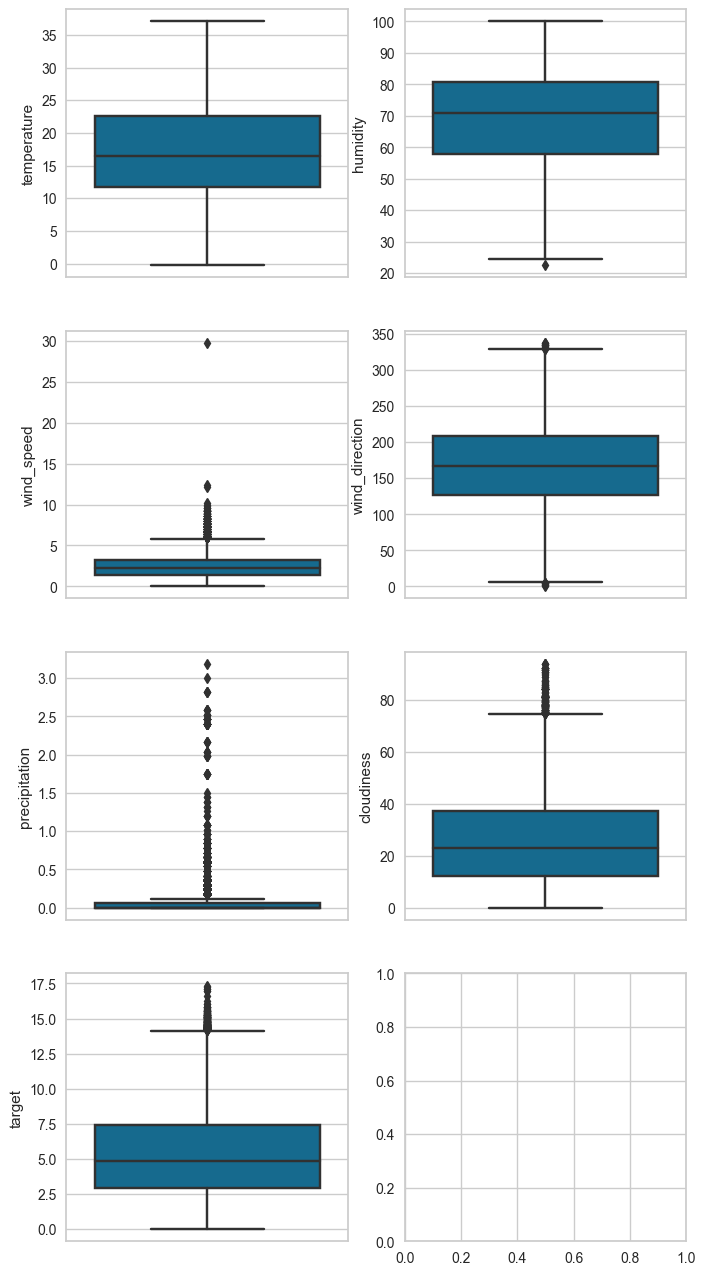

In [12]:
### boxplot 시각화

fig, axes = plt.subplots(4,2, figsize = (8,16))

sns.boxplot(y = quan_df['temperature'], ax = axes[0][0])
sns.boxplot(y = quan_df['humidity'], ax = axes[0][1])

sns.boxplot(y = quan_df['wind_speed'], ax = axes[1][0])
sns.boxplot(y = quan_df['wind_direction'], ax=axes[1][1])

sns.boxplot(y = quan_df['precipitation'], ax=axes[2][0])
sns.boxplot(y = quan_df['cloudiness'], ax=axes[2][1])

sns.boxplot(y = quan_df['target'], ax=axes[3][0])

plt.show()

- 각각의 feature 들에서 이상치가 일부 존재함을 확인할 수 있다.

### **1-2. 평가용 데이터(test data)**

In [13]:
test = pd.read_csv('./datasets/test.csv')
test.head()

,id,temperature,pressure,humidity,wind_speed,wind_direction,precipitation,snowing,cloudiness
0,TEST_00000,20.702000,1021.0,76.4,2.0,104.8,0.00,False,23.0
1,TEST_00001,18.673669,1014.4,59.6,2.4,179.2,0.12,False,32.4
2,TEST_00002,29.908000,1020.6,49.6,2.6,78.0,0.60,False,23.0
3,TEST_00003,24.504000,1014.6,61.0,1.8,118.0,0.00,False,15.0
4,TEST_00004,12.590000,1011.4,70.8,1.8,110.0,0.12,False,34.0


In [14]:
test = test.drop(columns = ['id','pressure','snowing'])
test.head()

,temperature,humidity,wind_speed,wind_direction,precipitation,cloudiness
0,20.702000,76.4,2.0,104.8,0.00,23.0
1,18.673669,59.6,2.4,179.2,0.12,32.4
2,29.908000,49.6,2.6,78.0,0.60,23.0
3,24.504000,61.0,1.8,118.0,0.00,15.0
4,12.590000,70.8,1.8,110.0,0.12,34.0


In [15]:
### 데이터 정보 확인

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19275 entries, 0 to 19274
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   temperature     19275 non-null  float64
 1   humidity        19275 non-null  float64
 2   wind_speed      19275 non-null  float64
 3   wind_direction  19275 non-null  float64
 4   precipitation   19275 non-null  float64
 5   cloudiness      19275 non-null  float64
dtypes: float64(6)
memory usage: 903.6 KB


- 결측치는 존재하지 않음을 확인할 수 있다.

# **2. 데이터 전처리(Data Pre-processing)**

### **2-1. 이상치(Outlier) 처리**
- target 변수와 상관도가 높은 풍속(wind_speed) 변수의 이상치 제거

In [16]:
### 이상치 제거 함수

def outliers_cut(data):
    q1, q3 = np.percentile(data,[25,75])
    iqr = q3 - q1
    lwb = q1 - (iqr * 1.5) # 상한선
    upb = q3 + (iqr * 1.5) # 하한선
    
    out_idx = np.where((data > upb) | (data < lwb))
    
    return out_idx

In [17]:
### outlier 제거하기

wind_speed_out_idx = outliers_cut(train['wind_speed'])[0]
print(len(wind_speed_out_idx))

train = train.drop(wind_speed_out_idx,axis = 0)
train = train.reset_index(drop = True)
print(len(train))

446
18829


- 총 446개의 이상치 데이터 제거 진행

# **3. 모델링**

### **- 랜덤 시드 고정**
- 매번 고정된 결과를 얻기 위해서 사용
- seed를 고정하지 않는다면 같은 코드라도 매번 다른 결과가 나오게 된다.
    - 항상 동일한 결과를 얻기 위해서 사용

## **3-1. 기본 설정**

In [18]:
reg1 = setup(train, target = 'target', session_id = 42,data_split_shuffle=True) 

,Description,Value
0,Session id,42
1,Target,target
2,Target type,Regression
3,Original data shape,"(18829, 7)"
4,Transformed data shape,"(18829, 7)"
5,Transformed train set shape,"(13180, 7)"
6,Transformed test set shape,"(5649, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


In [19]:
### 모델 확인

models() # setup을 한 후에만 가능

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


In [20]:
### 모댈 비교

compare_models(sort = 'MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,2.1058,7.7906,2.7904,0.2005,0.4714,0.6660,0.1900
rf,Random Forest Regressor,2.1390,7.7103,2.7757,0.2089,0.4707,0.6803,0.1420
catboost,CatBoost Regressor,2.2087,7.9249,2.8142,0.1869,0.4751,0.6919,0.2570
lightgbm,Light Gradient Boosting Machine,2.2242,8.0011,2.8279,0.1789,0.4771,0.6997,0.1510
xgboost,Extreme Gradient Boosting,2.2448,8.3207,2.8837,0.1461,0.4839,0.6989,0.2830
gbr,Gradient Boosting Regressor,2.2695,8.1984,2.8625,0.1587,0.4838,0.7183,0.0450
huber,Huber Regressor,2.3086,8.6211,2.9352,0.1154,0.4839,0.6835,0.0290
ridge,Ridge Regression,2.3288,8.5071,2.9159,0.1271,0.4910,0.7313,0.0310
lar,Least Angle Regression,2.3288,8.5071,2.9159,0.1271,0.4910,0.7313,0.0320
lr,Linear Regression,2.3288,8.5071,2.9159,0.1271,0.4910,0.7313,1.9360


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

ExtraTreesRegressor(n_jobs=-1, random_state=42)

In [21]:
### 모델 생성, 저장
# mae를 기준으로 3개의 모델 생성, 저장

et = create_model('et',verbose = False)
rf = create_model('rf',verbose = False)
catboost = create_model('catboost', verbose = False)

In [22]:
### 모델 혼합

blend_top_3 = blend_models(estimator_list = [et, rf, catboost])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.2196,8.0689,2.8406,0.1998,0.4826,0.7072
1,2.0873,7.3480,2.7107,0.2117,0.4565,0.6402
2,2.1448,7.7204,2.7786,0.2186,0.4574,0.6516
3,2.0868,7.4509,2.7296,0.2368,0.4643,0.6775
4,2.1083,7.0909,2.6629,0.2385,0.4683,0.7013
5,2.0697,7.2059,2.6844,0.2605,0.4574,0.6493
6,2.1787,7.7746,2.7883,0.2571,0.4761,0.7047
7,2.0802,7.2360,2.6900,0.2223,0.4623,0.6707
8,2.0812,7.2886,2.6997,0.2150,0.4555,0.6439


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

- 혼합 후 유의미한 개선은 없다.
    - 가장 좋은 개별 모델인 Extra Trees Regressor(MAE: 2.1058) vs Blender(MAE: 2.1275)

In [23]:
### 모델 stacking

stack1 = stack_models(estimator_list = [rf, catboost], meta_model = et, restack = True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.2701,8.2960,2.8803,0.1773,0.4880,0.7195
1,2.1740,7.8428,2.8005,0.1586,0.4725,0.6766
2,2.2544,8.3785,2.8946,0.1520,0.4753,0.6841
3,2.1378,7.7541,2.7846,0.2058,0.4706,0.6850
4,2.2042,7.6725,2.7699,0.1761,0.4851,0.7321
5,2.1349,7.6349,2.7631,0.2164,0.4682,0.6667
6,2.2299,8.1531,2.8554,0.2210,0.4869,0.7255
7,2.1635,7.6310,2.7624,0.1798,0.4735,0.6923
8,2.1399,7.7013,2.7751,0.1705,0.4632,0.6468


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

- Stacking 이후 유의미한 개선은 없음
    - 여전히 가장 성능이 좋은 기본 hyper parameter로 tuning된 모델은 Extra Trees Regressor(MAE: 2.1058)이다.

## **3-2. 전처리 심화**

In [24]:
reg2 = setup(train, target = 'target', session_id = 42, 
             normalize = True, normalize_method = 'zscore', # 표준화
             transformation = True, transformation_method = 'yeo-johnson', transform_target = True, # 데이터 변환
             polynomial_features = True, polynomial_degree = 2, remove_outliers = True, outliers_threshold = 0.01,
             )

,Description,Value
0,Session id,42
1,Target,target
2,Target type,Regression
3,Original data shape,"(18829, 7)"
4,Transformed data shape,"(18697, 28)"
5,Transformed train set shape,"(13048, 28)"
6,Transformed test set shape,"(5649, 28)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


In [25]:
### 모델 비교

compare_models(sort = 'MAE') 

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,2.0600,7.8063,2.7932,0.1990,0.4562,0.5846,0.1800
rf,Random Forest Regressor,2.1091,7.8074,2.7934,0.1988,0.4542,0.5961,0.1420
catboost,CatBoost Regressor,2.1775,8.0697,2.8396,0.1722,0.4611,0.6131,0.0580
lightgbm,Light Gradient Boosting Machine,2.1925,8.1557,2.8547,0.1635,0.4631,0.6204,0.0740
xgboost,Extreme Gradient Boosting,2.2116,8.4395,2.9041,0.1341,0.4737,0.6225,0.0540
gbr,Gradient Boosting Regressor,2.2493,8.4199,2.9007,0.1362,0.4698,0.6374,0.0680
huber,Huber Regressor,2.2741,8.6000,2.9315,0.1177,0.4775,0.6517,0.0560
lr,Linear Regression,2.2868,8.6408,2.9384,0.1136,0.4754,0.6479,0.0580
ridge,Ridge Regression,2.2893,8.6506,2.9401,0.1126,0.4759,0.6493,0.0550
br,Bayesian Ridge,2.2931,8.6637,2.9424,0.1112,0.4762,0.6502,0.0600


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

ExtraTreesRegressor(n_jobs=-1, random_state=42)

In [26]:
### 모델 튜닝

et = create_model('et')
rf = create_model('rf')
catboost = create_model('catboost')
lightgbm = create_model('lightgbm')
xgboost = create_model('xgboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.1168,8.1818,2.8604,0.1886,0.4689,0.6052
1,2.0211,7.5754,2.7523,0.1873,0.4478,0.5575
2,2.0817,8.0353,2.8347,0.1867,0.4507,0.5699
3,2.0352,7.7593,2.7856,0.2053,0.4534,0.5821
4,2.0412,7.2890,2.6998,0.2173,0.4575,0.6109
5,2.0144,7.5853,2.7541,0.2215,0.4472,0.5592
6,2.1023,8.1585,2.8563,0.2204,0.4660,0.6075
7,2.0090,7.4384,2.7273,0.2005,0.4501,0.5786
8,2.0164,7.5479,2.7473,0.1871,0.4475,0.5661


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.1868,8.2032,2.8641,0.1865,0.4677,0.6225
1,2.0576,7.5214,2.7425,0.1931,0.4448,0.5669
2,2.1300,8.0456,2.8365,0.1857,0.4480,0.5761
3,2.0683,7.6418,2.7644,0.2173,0.4500,0.5997
4,2.0934,7.3720,2.7151,0.2083,0.4573,0.6234
5,2.0621,7.5292,2.7439,0.2273,0.4446,0.5706
6,2.1453,8.0414,2.8357,0.2316,0.4590,0.6120
7,2.0472,7.4880,2.7364,0.1952,0.4491,0.5878
8,2.0633,7.6051,2.7577,0.1809,0.4478,0.5758


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.2653,8.5738,2.9281,0.1497,0.4765,0.6430
1,2.1239,7.7703,2.7875,0.1664,0.4498,0.5792
2,2.1890,8.2521,2.8726,0.1648,0.4536,0.5862
3,2.1490,7.9761,2.8242,0.1831,0.4587,0.6187
4,2.1432,7.4320,2.7262,0.2019,0.4590,0.6322
5,2.1077,7.6706,2.7696,0.2128,0.4489,0.5828
6,2.2319,8.4547,2.9077,0.1921,0.4714,0.6385
7,2.1280,7.7159,2.7778,0.1707,0.4546,0.6086
8,2.1408,7.8965,2.8101,0.1495,0.4550,0.5941


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.2748,8.6639,2.9435,0.1408,0.4766,0.6436
1,2.1263,7.7088,2.7765,0.1730,0.4477,0.5816
2,2.2046,8.3986,2.8980,0.1500,0.4559,0.5945
3,2.1666,8.0642,2.8398,0.1740,0.4615,0.6285
4,2.1702,7.5992,2.7567,0.1840,0.4661,0.6508
5,2.1240,7.8241,2.7972,0.1970,0.4523,0.5868
6,2.2599,8.6095,2.9342,0.1773,0.4737,0.6461
7,2.1160,7.7179,2.7781,0.1705,0.4559,0.6119
8,2.1514,7.9385,2.8175,0.1450,0.4561,0.5995


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.2714,8.8983,2.9830,0.1175,0.4883,0.6495
1,2.1670,8.1588,2.8564,0.1247,0.4623,0.5879
2,2.2504,8.7572,2.9593,0.1137,0.4729,0.6092
3,2.1627,8.1516,2.8551,0.1651,0.4647,0.6193
4,2.2026,8.0001,2.8284,0.1409,0.4756,0.6440
5,2.1456,8.0143,2.8310,0.1775,0.4591,0.5913
6,2.2612,8.8444,2.9739,0.1549,0.4828,0.6439
7,2.1857,8.2223,2.8674,0.1163,0.4747,0.6296
8,2.1535,8.0684,2.8405,0.1310,0.4628,0.6002


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [28]:
et = tune_model(et, n_iter = 10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.3340,8.9230,2.9871,0.1151,0.4856,0.6742
1,2.2230,8.2608,2.8742,0.1137,0.4649,0.6258
2,2.2986,8.8536,2.9755,0.1039,0.4720,0.6397
3,2.2495,8.5190,2.9187,0.1274,0.4773,0.6658
4,2.2616,8.0510,2.8374,0.1354,0.4784,0.6925
5,2.2078,8.2051,2.8645,0.1579,0.4666,0.6335
6,2.3307,8.9862,2.9977,0.1413,0.4866,0.6837
7,2.2160,8.0626,2.8395,0.1334,0.4694,0.6555
8,2.2026,8.0838,2.8432,0.1293,0.4643,0.6341


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [29]:
rf = tune_model(rf, n_iter = 10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.2910,8.6876,2.9475,0.1384,0.4766,0.6464
1,2.1306,7.7699,2.7875,0.1664,0.4504,0.5904
2,2.2018,8.3336,2.8868,0.1565,0.4544,0.5971
3,2.1641,8.0053,2.8294,0.1801,0.4590,0.6244
4,2.1630,7.5474,2.7472,0.1895,0.4614,0.6426
5,2.1359,7.8256,2.7974,0.1969,0.4513,0.5931
6,2.2411,8.4797,2.9120,0.1897,0.4694,0.6386
7,2.1346,7.7183,2.7782,0.1704,0.4548,0.6143
8,2.1297,7.7368,2.7815,0.1667,0.4505,0.5931


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [30]:
catboost = tune_model(catboost, n_iter = 10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.3220,8.9093,2.9848,0.1165,0.4846,0.6593
1,2.1970,8.1340,2.8520,0.1273,0.4585,0.6015
2,2.2750,8.7241,2.9537,0.1170,0.4659,0.6155
3,2.2194,8.3164,2.8838,0.1482,0.4709,0.6492
4,2.2414,8.0212,2.8322,0.1386,0.4758,0.6645
5,2.1875,8.0521,2.8376,0.1736,0.4608,0.6090
6,2.3063,8.8261,2.9709,0.1566,0.4793,0.6551
7,2.1969,8.0357,2.8347,0.1363,0.4645,0.6330
8,2.1896,8.0745,2.8416,0.1303,0.4595,0.6095


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [32]:
lightgbm = tune_model(lightgbm, n_iter = 10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.3013,8.7767,2.9625,0.1296,0.4792,0.6519
1,2.1768,7.9909,2.8268,0.1427,0.4549,0.5983
2,2.2567,8.6447,2.9402,0.1250,0.4627,0.6098
3,2.1928,8.1369,2.8525,0.1666,0.4650,0.6413
4,2.2193,7.8060,2.7939,0.1617,0.4696,0.6621
5,2.1821,8.0195,2.8319,0.1770,0.4592,0.6102
6,2.2919,8.7237,2.9536,0.1664,0.4769,0.6548
7,2.1611,7.8291,2.7980,0.1585,0.4599,0.6251
8,2.1754,7.9650,2.8222,0.1421,0.4571,0.6058


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [33]:
xgboost = tune_model(xgboost, n_iter = 10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.2898,8.7424,2.9567,0.1330,0.4789,0.6473
1,2.1339,7.7698,2.7874,0.1664,0.4498,0.5817
2,2.2390,8.6131,2.9348,0.1282,0.4625,0.5999
3,2.1642,8.0921,2.8447,0.1712,0.4631,0.6299
4,2.1649,7.5622,2.7499,0.1879,0.4630,0.6438
5,2.1248,7.7938,2.7917,0.2001,0.4528,0.5891
6,2.2433,8.5059,2.9165,0.1872,0.4721,0.6397
7,2.1355,7.8246,2.7973,0.1590,0.4564,0.6104
8,2.1426,7.8992,2.8106,0.1492,0.4564,0.6004


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


- 튜닝된 모델이 별다른 성능 개선을 보이지 못함
    - 원본 모델들을 혼합

In [34]:
### 모델 혼합

blend_all = blend_models(estimator_list = [et, rf, catboost,
                                           lightgbm, xgboost])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.2076,8.2427,2.8710,0.1826,0.4666,0.6259
1,2.0713,7.4526,2.7299,0.2005,0.4412,0.5671
2,2.1475,8.0468,2.8367,0.1856,0.4465,0.5783
3,2.0919,7.6881,2.7727,0.2126,0.4501,0.6036
4,2.0993,7.2245,2.6878,0.2242,0.4535,0.6242
5,2.0655,7.4638,2.7320,0.2340,0.4420,0.5709
6,2.1761,8.1174,2.8491,0.2244,0.4609,0.6214
7,2.0655,7.4217,2.7243,0.2023,0.4460,0.5923
8,2.0811,7.5739,2.7521,0.1843,0.4457,0.5798


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

- stacking 이후 성능 개선은 없다.

## **3-3. 모델 성능 평가**
- 최종 모델로 ExtraTreesRegressor(n_jobs=-1, random_state=42) 선택

In [36]:
final_model = finalize_model(et)
evaluate_model(final_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

# **6. 제출 파일 생성**

In [37]:
### 정답 파일 예시 확인

submit = pd.read_csv('./datasets/sample_submission.csv')
submit.head(3) # 3개의 데이터만 확인

,id,target
0,TEST_00000,0
1,TEST_00001,0
2,TEST_00002,0


In [39]:
### 최종값 예측

prediction = predict_model(final_model, data = test)

In [40]:
prediction

,temperature,humidity,wind_speed,wind_direction,precipitation,cloudiness,prediction_label
0,20.702000,76.400002,2.0,104.800003,0.00,23.000000,2.270706
1,18.673668,59.599998,2.4,179.199997,0.12,32.400002,2.196376
2,29.908001,49.599998,2.6,78.000000,0.60,23.000000,2.241450
3,24.504000,61.000000,1.8,118.000000,0.00,15.000000,2.024031
4,12.590000,70.800003,1.8,110.000000,0.12,34.000000,1.959571
...,...,...,...,...,...,...,...
19270,25.180000,64.800003,1.6,122.000000,0.00,34.000000,2.189447
19271,16.940001,72.400002,1.8,245.600006,0.00,19.000000,1.774352
19272,9.032000,94.400002,2.2,219.199997,0.00,18.000000,1.981664
19273,15.774000,79.000000,0.8,182.000000,0.00,27.000000,1.943030


In [42]:
submit['target'] = prediction['prediction_label']
submit.head()

,id,target
0,TEST_00000,2.270706
1,TEST_00001,2.196376
2,TEST_00002,2.241450
3,TEST_00003,2.024031
4,TEST_00004,1.959571


In [43]:
### 제출 파일 저장

submit.to_csv('./submit_ver14.csv', index=False)